## Setup

In [22]:
!pip install pandas numpy matplotlib seaborn

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

data_path =  "../data/r2/raw.csv"
data_train_path = "../data/r2/train.csv"
data_target_path = "../data/r2/target.csv"

## Utils

In [24]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])

    return df

df = load_data(data_path)

## EDA

### Data Quality and Target Distribution

No missing values found.


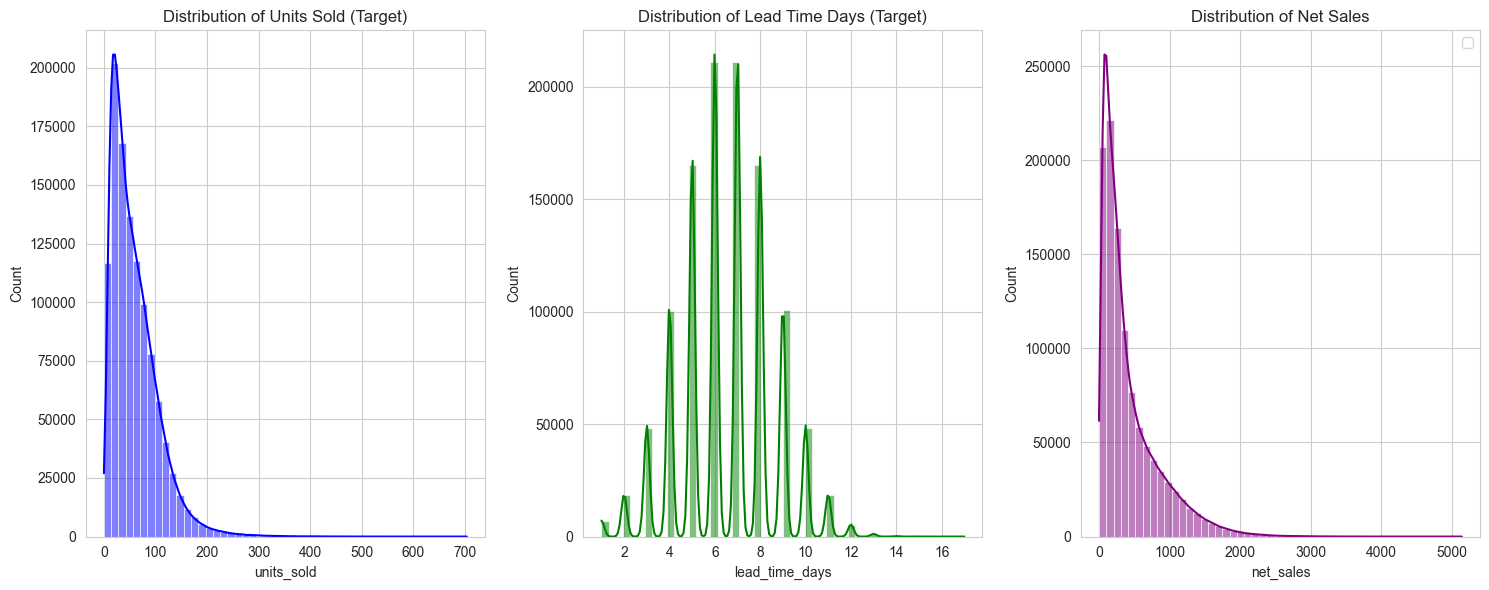

Skewness of Units Sold: 1.67


In [57]:
missing_vals = df.isnull().sum()
if missing_vals.sum() > 0:
    print("Missing Values:\n", missing_vals[missing_vals > 0])
else:
    print("No missing values found.")

# Visualize the distribution of Target Variables
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
# Target 1: Units Sold (Demand)
sns.histplot(df['units_sold'], bins=50, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribution of Units Sold (Target)')

# Target 2: Lead Time Days
sns.histplot(df['lead_time_days'], bins=50, kde=True, ax=axes[1], color='green')
axes[1].set_title('Distribution of Lead Time Days (Target)')

# Check Net Sales
sns.histplot(df['net_sales'], bins=50, kde=True, ax=axes[2], color='purple')
axes[2].set_title('Distribution of Net Sales')

plt.tight_layout()
plt.legend()
plt.show()

# Insight Code: Skewness check
print(f"Skewness of Units Sold: {df['units_sold'].skew():.2f}")

### Stockout & Censored Demand Analysis

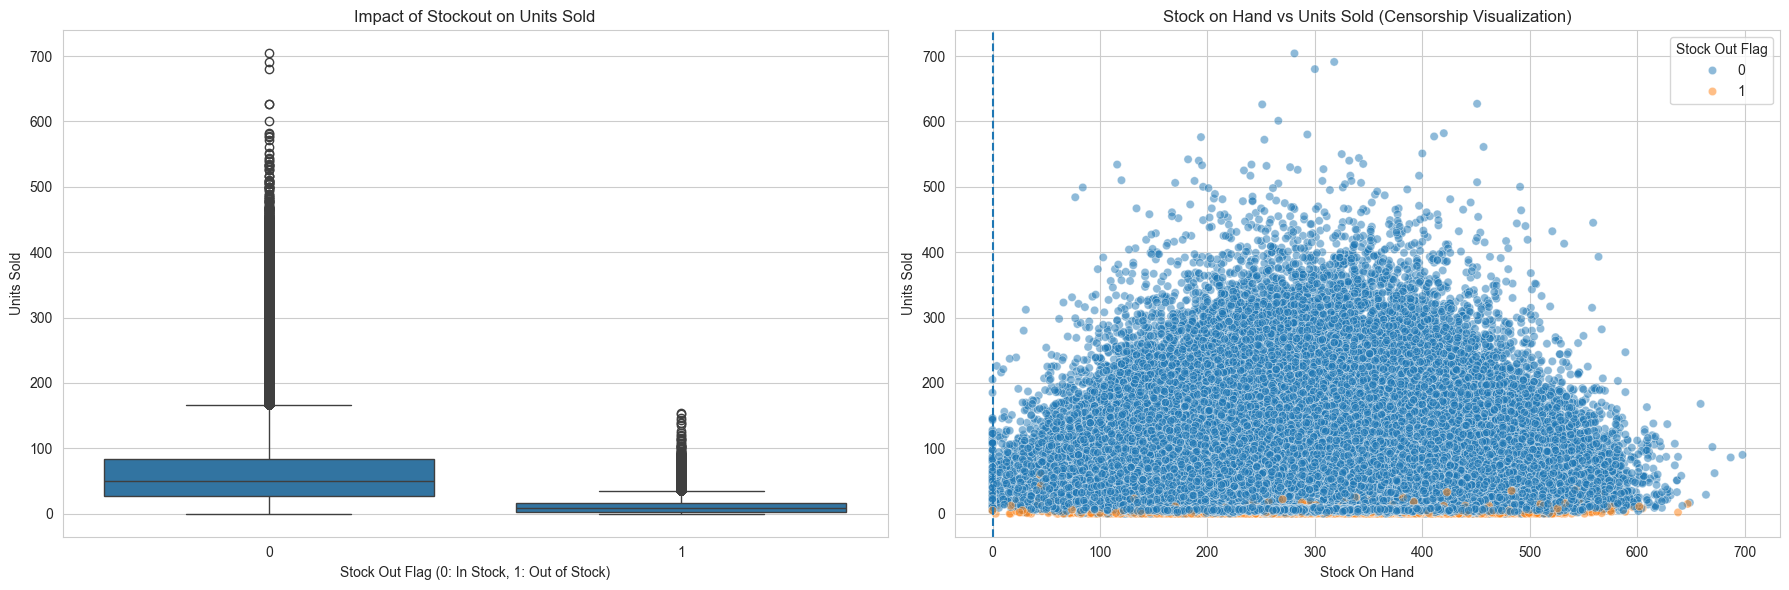

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --- Plot 1: Boxplot - Impact of Stockout ---
sns.boxplot(
    x='stock_out_flag',
    y='units_sold',
    data=df,
    ax=axes[0]
)
axes[0].set_title('Impact of Stockout on Units Sold')
axes[0].set_xlabel('Stock Out Flag (0: In Stock, 1: Out of Stock)')
axes[0].set_ylabel('Units Sold')

# --- Plot 2: Scatterplot - Stock on Hand vs Units Sold ---
sns.scatterplot(
    x='stock_on_hand',
    y='units_sold',
    hue='stock_out_flag',
    alpha=0.5,
    data=df,
    ax=axes[1]
)
axes[1].axvline(x=0, linestyle='--')
axes[1].set_title('Stock on Hand vs Units Sold (Censorship Visualization)')
axes[1].set_xlabel('Stock On Hand')
axes[1].set_ylabel('Units Sold')
axes[1].legend(title='Stock Out Flag')

plt.tight_layout()
plt.show()

### Temporal Pattern & Seasonality

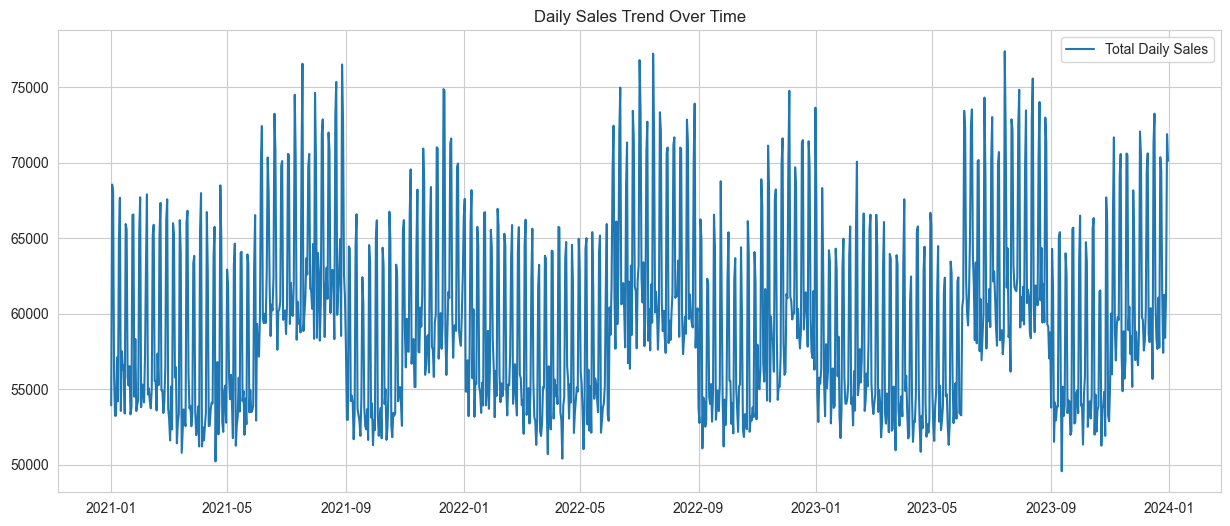

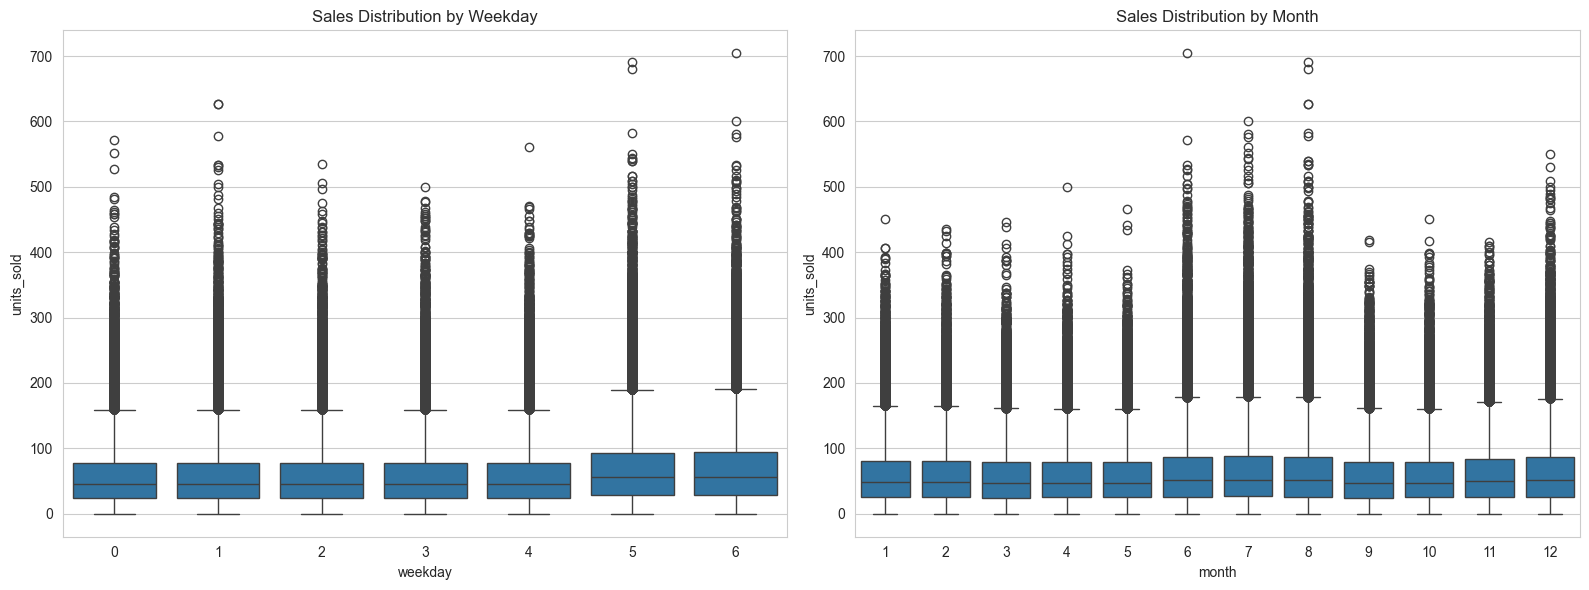

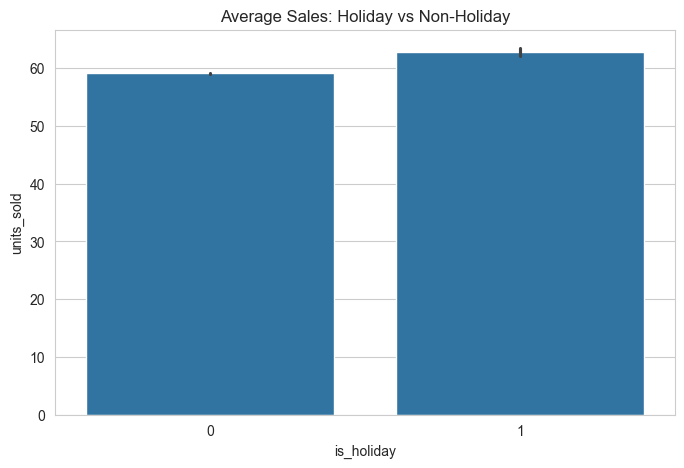

In [52]:
# Aggregate sales by date
daily_sales = df.groupby('date')['units_sold'].sum().reset_index()

plt.figure(figsize=(15, 6))
plt.plot(daily_sales['date'], daily_sales['units_sold'], label='Total Daily Sales')
plt.title('Daily Sales Trend Over Time')
plt.legend()
plt.show()

# Weekly and Monthly Seasonality
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Day of Week Impact (0=Monday, 6=Sunday)
sns.boxplot(x='weekday', y='units_sold', data=df, ax=axes[0])
axes[0].set_title('Sales Distribution by Weekday')

# Month Impact
sns.boxplot(x='month', y='units_sold', data=df, ax=axes[1])
axes[1].set_title('Sales Distribution by Month')

plt.tight_layout()
plt.show()

# Holiday Effect
plt.figure(figsize=(8, 5))
sns.barplot(x='is_holiday', y='units_sold', data=df)
plt.title('Average Sales: Holiday vs Non-Holiday')
plt.show()

### Price, Promotion & External Factors

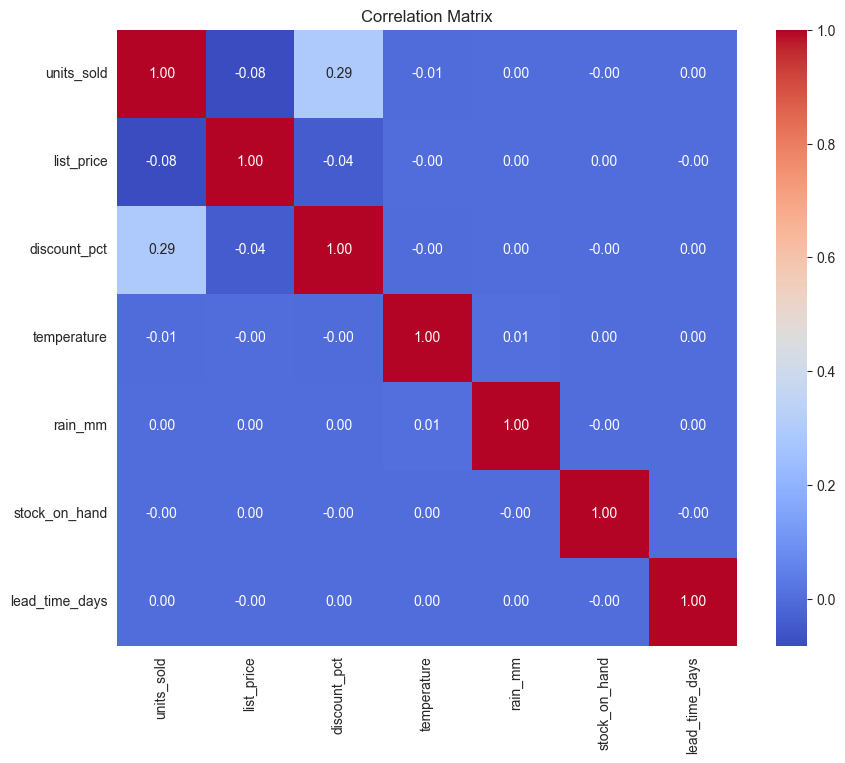

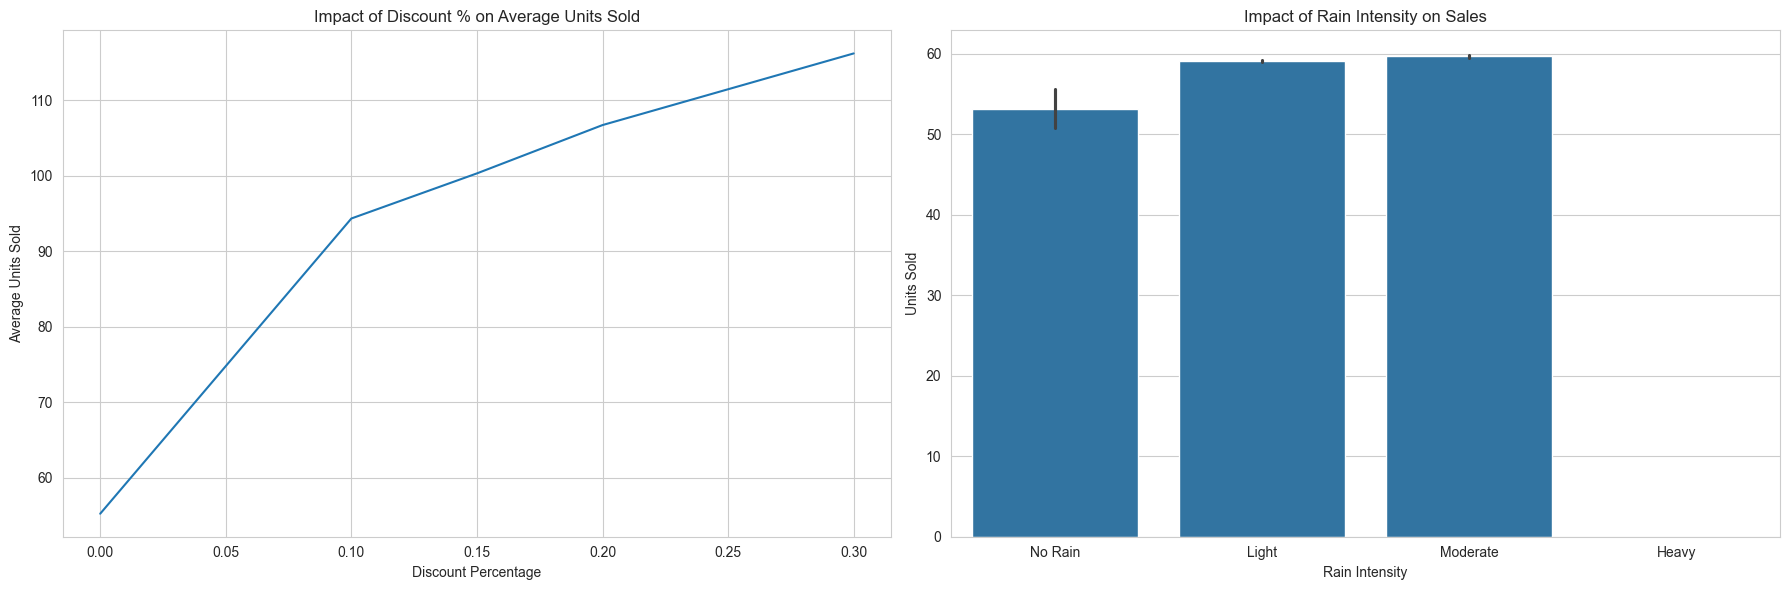

In [59]:
# Correlation Heatmap for Numerical Features
numerical_cols = ['units_sold', 'list_price', 'discount_pct', 'temperature',
                  'rain_mm', 'stock_on_hand', 'lead_time_days']
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Price Elasticity Check: Discount vs Units Sold
df['rain_bin'] = pd.cut(
    df['rain_mm'],
    bins=[-1, 0, 5, 20, 100],
    labels=['No Rain', 'Light', 'Moderate', 'Heavy']
)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --- Plot 1: Discount vs Avg Units Sold ---
sns.lineplot(
    x='discount_pct',
    y='units_sold',
    data=df,
    estimator='mean',
    errorbar=None,
    ax=axes[0]
)
axes[0].set_title('Impact of Discount % on Average Units Sold')
axes[0].set_xlabel('Discount Percentage')
axes[0].set_ylabel('Average Units Sold')

# --- Plot 2: Rain Impact on Sales ---
sns.barplot(
    x='rain_bin',
    y='units_sold',
    data=df,
    ax=axes[1]
)
axes[1].set_title('Impact of Rain Intensity on Sales')
axes[1].set_xlabel('Rain Intensity')
axes[1].set_ylabel('Units Sold')

plt.tight_layout()
plt.show()

### Supply chain & Lead time analysis

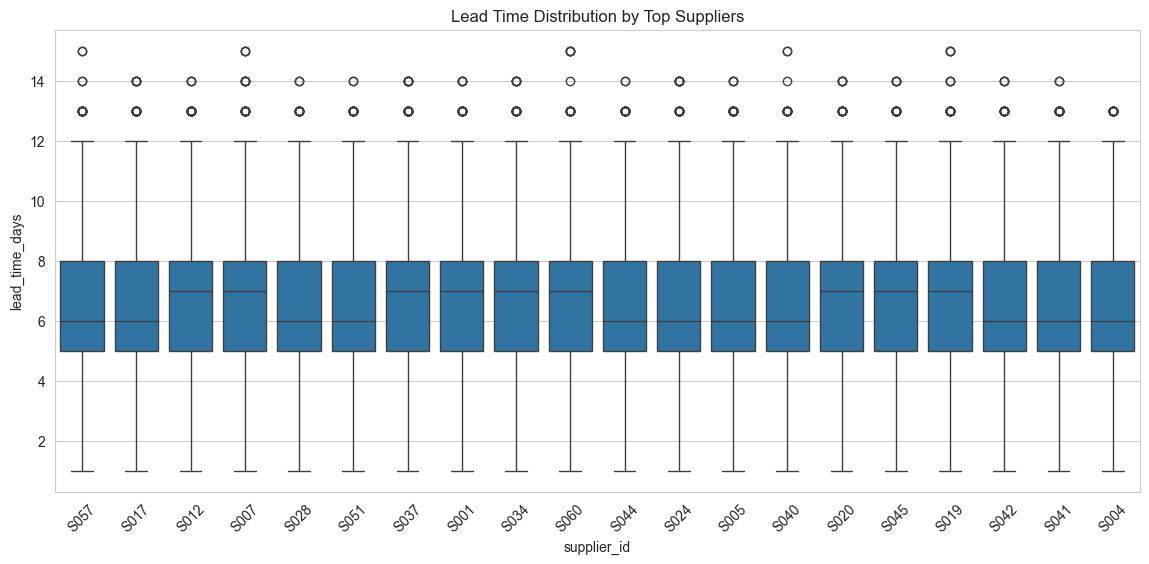

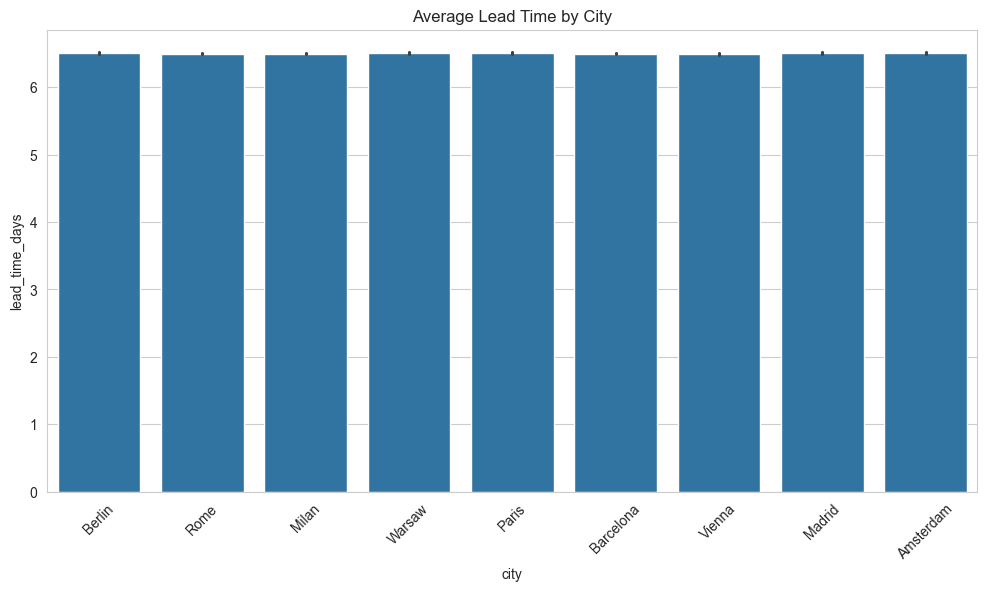

In [54]:
# Lead time by Supplier (Identify unreliable suppliers)
plt.figure(figsize=(14, 6))
top_suppliers = df['supplier_id'].value_counts().head(20).index
sns.boxplot(x='supplier_id', y='lead_time_days', data=df[df['supplier_id'].isin(top_suppliers)])
plt.title('Lead Time Distribution by Top Suppliers')
plt.xticks(rotation=45)
plt.show()

# Lead time by City/Country (Logistics constraints)
plt.figure(figsize=(12, 6))
sns.barplot(x='city', y='lead_time_days', data=df)
plt.title('Average Lead Time by City')
plt.xticks(rotation=45)
plt.show()